In [1]:
import numpy as np

from keras.models import Model, load_model
from keras.datasets import cifar10
import keras.backend as K

from pgd_attack import AdversarialExampleGenerator
from svm_model import SVMModel

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm

import os
import math
from statistics import mean, median

Using TensorFlow backend.


In [2]:
epsilon = 8 / 255
batch_size = 64
model_path = "saved_models/CIFAR10_SmallResNet_eps_0.031/Apr26_17-05-26/weights_050_0.39.h5"

In [3]:
####################
# Data preparation #
####################

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Leave aside a validation set
x_valid = x_train[-5000:]
y_valid = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

# Input image dimensions
input_shape = x_train.shape[1:]

# Normalize data
x_train = x_train.astype("float32") / 255
x_valid = x_valid.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

45000 train samples
5000 validation samples
10000 test samples


In [4]:
########################
# Model initialisation #
########################

model = load_model(model_path)

model.xent_loss = model.total_loss
for loss in model.losses:
    model.xent_loss -= loss

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
###################
# Data generators #
###################

valid_adv_generator = AdversarialExampleGenerator(model, x_valid, y_valid,
                                                  batch_size=batch_size,
                                                  epsilon=epsilon,
                                                  k=40,
                                                  a=epsilon / 10.0,
                                                  incremental=False,
                                                  shuffle=False)

test_adv_generator  = AdversarialExampleGenerator(model, x_test, y_test,
                                                  batch_size=batch_size,
                                                  epsilon=epsilon,
                                                  k=40,
                                                  a=epsilon / 10.0,
                                                  incremental=False,
                                                  shuffle=False)

In [6]:
x_acc = []
for x_batch, _, _ in tqdm(valid_adv_generator):
    x_acc.append(x_batch)
x_valid_adv = np.concatenate(x_acc, axis=0)

x_acc = []
for x_batch, _, _ in tqdm(test_adv_generator):
    x_acc.append(x_batch)
x_test_adv = np.concatenate(x_acc, axis=0)

100%|██████████| 157/157 [1:24:51<00:00, 24.59s/it]


In [7]:
input_tensor = model.input
output_tensor = model.layers[-2].output

representation_model = Model(inputs=input_tensor, outputs=output_tensor)

train_nat_representations = representation_model.predict(x_train)
valid_nat_representations = representation_model.predict(x_valid)
valid_adv_representations = representation_model.predict(x_valid_adv)
test_nat_representations = representation_model.predict(x_test)
test_adv_representations = representation_model.predict(x_test_adv)

In [8]:
y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)

## SVM model

In [9]:
svm_model = SVMModel(train_nat_representations, y_train)

## Predictions

In [11]:
model_predict_valid_nat = np.argmax(model.predict(x_valid), axis=1)
model_predict_valid_adv = np.argmax(model.predict(x_valid_adv), axis=1)

svm_predict_valid_nat = svm_model.predict(valid_nat_representations)
svm_predict_valid_adv = svm_model.predict(valid_adv_representations)

## How good is the SVM as an approximation to the output layer?

In [12]:
print("SVM natural train accuracy", svm_model.test(train_nat_representations, y_train))
print("Model natural train accuracy", model.evaluate(x_train, y_train, verbose=0)[1])

SVM natural train accuracy 0.8362888888888889
Model natural train accuracy 0.8034222222222223


In [13]:
print("SVM natural valid accuracy", svm_model.test(valid_nat_representations, y_valid))
print("Model natural valid accuracy", model.evaluate(x_valid, y_valid, verbose=0)[1])

SVM natural valid accuracy 0.7698
Model natural valid accuracy 0.7436


In [14]:
# Adversarial train accuracy
print("SVM adversarial valid accuracy", svm_model.test(valid_adv_representations, y_valid))
print("Model adversarial valid accuracy", model.evaluate(x_valid_adv, y_valid, verbose=0)[1])

SVM adversarial valid accuracy 0.3626
Model adversarial valid accuracy 0.3872


In [15]:
print(
    "Top 1 natural valid concurrence of SVM",
    np.count_nonzero(svm_predict_valid_nat == model_predict_valid_nat) / len(x_valid)
)

Top 1 natural valid concurrence of SVM 0.866


In [16]:
print(
    "Top 1 adversarial valid concurrence of SVM",
    np.count_nonzero(svm_predict_valid_adv == model_predict_valid_adv) / len(x_valid_adv)
)

Top 1 adversarial valid concurrence of SVM 0.807


In [17]:
count = 0
for p, q in zip(svm_model.predict(valid_nat_representations), np.argsort(model.predict(x_valid), axis=1)[:, -2:]):
    if p in q:
        count += 1
print("Top 2 natural valid concurrence of SVM", count / len(x_valid))

Top 2 natural valid concurrence of SVM 0.9618


In [18]:
count = 0
for p, q in zip(svm_model.predict(valid_adv_representations), np.argsort(model.predict(x_valid_adv), axis=1)[:, -2:]):
    if p in q:
        count += 1
print("Top 2 adversarial valid concurrence of SVM", count / len(x_valid_adv))

Top 2 adversarial valid concurrence of SVM 0.9532


In [52]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ["\\usepackage[lf,minionint,footnotefigures]{MinionPro}"],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
#               'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'mathtext.default': 'regular'
    }

    matplotlib.rcParams.update(params)

%matplotlib inline

latexify(fig_width=2.6, fig_height=2.0951352218621437)

In [53]:
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


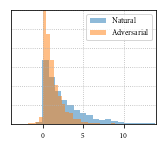

In [54]:
valid_nat_dists = svm_model.get_predicted_class_decision_boundary_distances(
                             valid_nat_representations,
                             svm_predict_valid_nat)

valid_adv_dists = svm_model.get_predicted_class_decision_boundary_distances(
                             *zip(*[(x,y) for (x,y,z) in  zip(
                                 valid_adv_representations,
                                 svm_predict_valid_adv,
                                 y_valid
                             ) if y != z])
                         )

nat_min_dists = list(map(lambda xs: min(xs), valid_nat_dists))
adv_min_dists = list(map(lambda xs: min(xs), valid_adv_dists))

# plt.title("Min distance in natural model")
plt.hist(nat_min_dists, normed=True, bins=25, alpha=0.5, label="Natural")
plt.hist(adv_min_dists, normed=True, bins=25, alpha=0.5, label="Adversarial")
plt.legend()
# plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().set_xlim([-4, 14])
plt.gca().set_ylim([0, 0.6])
plt.grid(True, "both", linestyle="dotted")
for tic in plt.gca().yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
plt.savefig(os.path.join(figures_dir, "svm_dists_cifar10_RN_8_eps_8.pdf"), bbox_inches="tight", pad_inches=0)

## Validation accuracy

In [21]:
def calculate_accuracy(representations, predictions, y, is_adv, adv_pred_function):
    dists = svm_model.get_predicted_class_decision_boundary_distances(
                                 representations,
                                 predictions)
        
    if not is_adv:
        correct_predict = [not adv_pred_function(xs) and a == b
                           for (xs,a,b) in zip(dists, predictions, y)]
    else:
        correct_predict = [adv_pred_function(xs) or a == b
                           for (xs,a,b) in zip(dists, predictions, y)]
    
    return np.sum(correct_predict) / len(representations)

adv_pred_function = lambda xs: min(xs) < 0.75

print(calculate_accuracy(valid_nat_representations,
                         svm_predict_valid_nat,
                         y_valid,
                         False,
                         adv_pred_function),
      "accuracy on natural images")


print(calculate_accuracy(valid_adv_representations,
                         svm_predict_valid_adv,
                         y_valid,
                         True,
                         adv_pred_function),
      "accuracy on adversarial images")

0.7874 accuracy on natural images
0.7736 accuracy on adversarial images
